# PRACTICE DESIGNING CLOSED LOOP SYSTEMS

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

This notebook describes the proportional, integral, and differential controllers.

# Preliminaries

In [ ]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
from IPython.display import HTML, Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

In [ ]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

In [ ]:
# Constants
CONSTANT_DCT = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
s = sympy.Symbol("s")
REF = 10

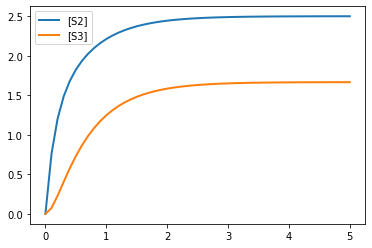

In [ ]:
MODEL1 = """
$S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 1
k2 = 2
k3 = 3
k4 = 4
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR = te.loada(MODEL1)
RR.simulate()
RR.plot()

# Helpers

In [ ]:
def plotTFs(Gs, kp=0, ki=0, kd=0, times=TIMES, ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    kp: float
    ki: float
    kd: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0])  \
        + control.TransferFunction([kd, 0], [1])
    Fs = 1
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=times, U=1)
        plt.plot(result.t.flatten(), result.y.flatten())
    # Refine plots
    plt.legend(list(tf_dct.keys()))
    xmax = max(result.t.flatten())
    plt.plot([0, xmax], [0, 0], linestyle="--", color="black")
    plt.plot([0, xmax], [1, 1], linestyle="--", color="grey")
    plt.ylim([-5, 5])
    title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
    plt.title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, kp=10, ylim=[0, 3], title="Example", is_plot=False)
assert(len(dct) == 4)
assert("TransferFunction" in str(type(dct["HRYs"])))
print("OK!")

OK!


In [ ]:
def makeHRY(model, input_name, output_name, time=0, kp=0, ki=0, kd=0):
    """
    Calculates the transfer function from the reference input to the output.
    
    Parameters
    ----------
    model: str
    input_name: str
    output_name: str
    time: float
    kp: float
    ki: float
    kd: float
    
    Returns
    -------
    control.TransferFunction
    """
    ctlsb = ctl.ControlSBML(model, input_names=[input_name], output_names=[output_name])
    Gs = ctlsb.makeTransferFunction(time=time)
    dct = plotTFs(Gs, kp=kp, ki=ki, kd=kd, is_plot=False)
    return dct["HRYs"]
    
    
# TESTS
tf = makeHRY(MODEL1, "S2", "S3", kp=0)
assert(tf.dcgain() == 0)
print("OK!")

OK!


# More On Filters

How do filters help with sinusoidal noise and disturbances?

We consider filters with a DC gain of one.
That is, given the positive $a$, the filter is $a e^{-at}$.
This has the transfer function $\frac{a}{a + s}$.

In [ ]:
# Create a testsbed
factory = ctl.IOSystemFactory()
fltr = factory.makeFilter("fltr", -1)
noise = factory.makeSinusoid("noise", 1, 5)
shift = factory.makeConstant("shift", 5)
sum = factory.makeAdder("sum")

In [ ]:
# Create the testbed
test_bed = control.interconnect(
  [noise, fltr, shift, sum ], 
  connections=[
    ["sum.in1", "noise.out"],
    ["sum.in2", "shift.out"],
    ['fltr.in', 'sum.out'],   
    
  ],
  outlist=["shift.out", "fltr.out"],
)

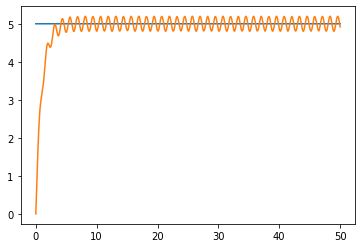

In [ ]:
# Simulate it
times = ctl.makeSimulationTimes(0, 50, 500)
result = control.input_output_response(test_bed, T=times)
plt.plot(result.t, result.outputs[0].flatten())
plt.plot(result.t, result.outputs[1].flatten())

# PID Controllers

The controllers considered here are systems that input the control error and produce a control signal used
to regulate the system under control.
The input signal is $e(t)$ and the output signal is $u(t)$.

A **proportional controller** has the parameter $k_P$.
This controller outputs a signal that is proportional to the control error.
That is, $u(t) = k_P e(t)$.
The transfer function for this controller is $H_{P} (s) = k_p$.

An **integral controller** has the parameter $k_I$.
This controller outputs a signal that is proportional to the *integral* of the control error.
That is, $u(t) = k_I \int_0^{t} e(\tau) d \tau$.
The transfer function for this controller is $H_{I} (s) = \frac{k_I}{s}$.

An **differential controller** has the parameter $k_D$.
This controller outputs a signal that is proportional to the derivative of the control error.
That is, $u(t) = k_D \frac{de(t)}{d t}$.
The transfer function for this controller is $H_{D} (s) = s k_D$.

These controllers can be used in combination.
For example, a PI controller produces 
$u(t) = k_P e(t) +  k_I \int_0^{t} e(\tau) d \tau + k_D \frac{d e(t)}{d t}$,
and its transfer function is $H_{CPI}(s) = k_P + \frac{k_I}{s} + s k_D$.

# Model of Glycoytic Oscillations (BioModels 206)

In [ ]:
MODEL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"

**Reactions in Glycolytic Oscillations**

``at`` is ``ATP``; ``s5`` is ``pyruvate``.

    v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
    v2: s2 -> 2 s3; compartment_*k2*s2;
    v3: s3 + na -> s4 + at_;compartment_*((k31*k32*s3*na*(atot - at_) 
        - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
    v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
    v5: s5 -> s6; compartment_*k5*s5;
    v7: at_ -> ; compartment_*k7*at_;
    v8: s3 -> na; compartment_*k8*s3*(ntot - na);
    v9: s6o -> ; compartment_*k9*s6o;
    v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
    v6: s6 -> na; compartment_*k6*s6*(ntot - na);
    v0:  -> s1; compartment_*k0;

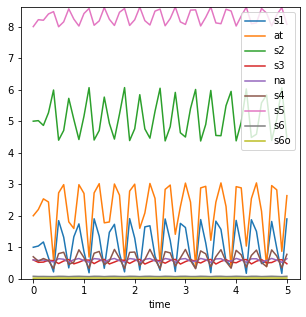

In [ ]:
ctlsb = ctl.ControlSBML(MODEL)
ctlsb.plotTrueModel(figsize=(5,5))

# Transfer Function Analysis

In [ ]:
tf = makeHRY(MODEL, "at", "s5", time=2.3, kp=1, ki=2, kd=0)
tf

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=1.27844e-51): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=2.78028e-23): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=2.78028e-23): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=2.78028e-23): result may not be accurate.



TransferFunction(array([-7.47253943e+01, -3.35369723e+05, -6.16533514e+08, -6.15450515e+11,
       -3.76347026e+14, -1.50458700e+17, -4.08313488e+19, -7.67858420e+21,
       -1.00807255e+24, -9.17579008e+25, -5.63762381e+27, -2.20599837e+29,
       -4.91794155e+30, -5.09556635e+31, -2.18501525e+32, -2.80216648e+32,
       -2.20953167e+31,  0.00000000e+00]), array([ 1.00000000e+00,  4.64424932e+03,  8.95566165e+06,  9.53558958e+09,
        6.32728055e+12,  2.78798232e+15,  8.43692518e+17,  1.77803838e+20,
        2.60314470e+22,  2.59620650e+24,  1.69018135e+26,  6.61119931e+27,
        1.29985293e+29,  7.25252007e+29, -1.40151684e+30,  3.08281372e+30,
        1.14558929e+32, -2.20953167e+31,  0.00000000e+00]))

In [ ]:
tf.dcgain()

nan

# Testbed

## Piece Parts of Testbed for Closed Loop System

In [ ]:
def callback_print(call_name, time, x_vec, u_vec, dct, outputs):
    """
    Callback function used by IOSystemFactory that prints the inputs.

    Parameters
    ----------
    name: name of the component
    time: float
    x_vec: list-float
    u_vec: list-float
    dct; dict
        additional constant parameters
    outputs: list-float
    is_output: bool

    Returns
    -------
    str
    """
    line = call_name
    line += "  %2.6f" % time
    line += "  %s" % str(x_vec)
    line += "  %s" % str(u_vec)
    line += "  %s" % str(outputs)
    line += "  %s" % str(dct)
    print(line)


In [ ]:
# Elements of the system

factory = ctl.IOSystemFactory()
kp = 0.005
ki = 0
kd = 0
input_name = "at"
output_name = "s5"
# Create the elements of the feedback loop
ctlsb = ctl.ControlSBML(MODEL, input_names=[input_name], output_names=[output_name])
system = ctlsb.makeNonlinearIOSystem("system")
controller = factory.makePIDController("controller", kp=kp, ki=ki, kd=kd)
sum_R_S = factory.makeAdder("sum_R_S")

In [ ]:
# Create the closed loop system
system_in = "system.%s" % input_name
system_out = "system.%s" % output_name
closed_loop = control.interconnect(
  [sum_R_S, system, controller ], 
  connections=[
    ['controller.in', 'sum_R_S.out'],    # e(t)
    [system_in,   'controller.out'],   # u(t)
    ['sum_R_S.in1', "-" + system_out],
  ],
  inplist=["sum_R_S.in2"],
  outlist=["sum_R_S.in2", system_in, system_out],
)

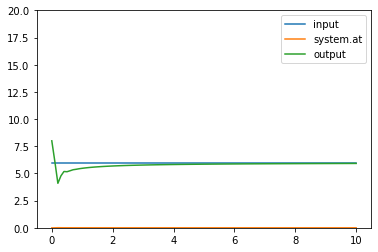

In [ ]:
X0 = ctl.makeStateVector(closed_loop)
times = ctl.makeSimulationTimes(start_time=0, end_time=10, points_per_time=10)
# Need the initial state
result = control.input_output_response(closed_loop, T=times, U=6, X0=X0)
plt.plot(result.t, result.outputs[0].flatten())
plt.plot(result.t, result.outputs[1].flatten())
plt.plot(result.t, result.outputs[2].flatten())
#plt.plot(result.t, result.outputs[3].flatten())
plt.ylim([0, 20])
legends = ["input", system_in, "output"]
plt.legend(legends)

In [ ]:
factory.report()

ValueError: ignored

## Create Evaluation Environment

# Evaluation Environment

We want to repeatedly evaluate different controller parameters.
This is cumbersome to do if we have to rerun multiple cells and reset various parameters.
It's much more efficient to create an evaluation function.

In [ ]:
def runTestbed(model=MODEL, input_name="at", output_name="s5", kp=0, ki=0, kd=0,
               is_plot=True):
    """
    Run the testbed and plot the results.
    
    Parameters
    ---------
    model: str
        System under control
    input_name: str
    output_name: str
    kp: float
    ki: float
    kd: float
    is_plot: bool
    
    Results
    -------
    control.InterconnectedSystem
    """
    # Construct elements of the closed loop system
    factory = ctl.IOSystemFactory()
    # Create the elements of the feedback loop
    ctlsb = ctl.ControlSBML(MODEL, input_names=[input_name],
                            output_names=[output_name])
    system = ctlsb.makeNonlinearIOSystem("system")
    controller = factory.makePIDController("controller", kp=kp, ki=ki, kd=kd)
    sum_R_S = factory.makeAdder("sum_R_S")
    # Construct the Interconnected system
    system_in = "system.%s" % input_name
    system_out = "system.%s" % output_name
    closed_loop = control.interconnect(
    [sum_R_S, system, controller ], 
    connections=[
        ['controller.in', 'sum_R_S.out'],    # e(t)
        [system_in,   'controller.out'],   # u(t)
        ['sum_R_S.in1', "-" + system_out],
    ],
    inplist=["sum_R_S.in2"],
    outlist=["sum_R_S.in2", system_in, system_out],
    )
    # Do the simulation and plot
    X0 = ctl.makeStateVector(closed_loop)
    times = ctl.makeSimulationTimes(start_time=0, end_time=10, points_per_time=10)
    # Need the initial state
    result = control.input_output_response(closed_loop, T=times, U=6, X0=X0)
    plt.plot(result.t, result.outputs[0].flatten())
    plt.plot(result.t, result.outputs[1].flatten())
    plt.plot(result.t, result.outputs[2].flatten())
    #plt.plot(result.t, result.outputs[3].flatten())
    plt.ylim([0, 20])
    legends = ["input", system_in, "output"]
    plt.legend(legends)
    if not is_plot:
        plt.close()
    #
    return closed_loop

# Tests
interconnect_sys = runTestbed(is_plot=False)
assert("Interconnect" in str(type(interconnect_sys)))
print("OK!")

OK!
